# Machine Learning Homework 01 – Report

## 1. – Solution

There were two problems to solve (problem 1 and problem 2). The first problem required implementing two functions to compute the pairwise distance matrix $Z$ of a random $N\times D$ matrix $X$:

1. A function using a two-level nested loop, iterating through all pairs $(i,j)$ and computing the corresponding entry $Z_{i,j}$

2. A function using numpy matrix operations (vectorization)

And the second problem required implementing two functions to compute the correlation matrix $R$ of a random $N\times D$ matrix $X$:

1. A function using a two-level nested loop

2. A function using vectorization

For each of these problems, we were asked to profile the performance of the functions on random matrices of row-size $N$ by plotting the running time as a function of $N$. Finally, the third problem required evaluating the running times of each function on three datasets in the `sklearn.datasets` library.

Since this report is written in a Jupyter Notebook, for simplicity's sake I will import libraries necessary for easily showing plots and other results in the notebook:

In [1]:
import math
from timeit import timeit
from typing import Tuple

import numpy as np
from numpy.random import rand
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer, load_digits
from tqdm import tqdm

### 1.1. – Problem 1

#### 1.1.1. – Pairwise Distance Matrix Using Loops

The pairwise Euclidean distance betweeen vectors `v1` and `v2` can be computed using the following function:

In [2]:
def pairwise_distance_loop(v1, v2):
    diff = v1 - v2
    payload = 0
    for d in diff:
        payload += d**2
    return math.sqrt(payload)

This sums the squares of the element-wise difference between the input vectors and takes the square root of the result – the definition of pairwise Euclidean distance.

Then, using this helper function, we can solve the first subproblem by initializing an empty $N\times N$ matrix `z` and simply looping over each row of the matrix `x` and, for each row, looping over all other rows (including the same row) and updating the corresponding entry of `z`:

In [3]:
def compute_pairwise_distance_loop(x):
    """

    :param x: 2d numpy array of dimension num_vectors x feature_dim
    :return: num_vectors x num_vectors 2d numpy array in which each
             (i, j)-entry is the pairwise euclidean distance between
             rows indexed as `i` and `j`.

    """
    num_vectors = x.shape[0]     # number of vectors in dataset
    z = np.zeros((num_vectors, num_vectors))
    for i in range(num_vectors):
        for j in range(num_vectors):
            # Note: pairwise_distance(x[i, :], x[j, :]) will give either
            # a small, nonzero float or NaN when taking pairwise_distance on
            # i = j, so best to just impute it to zero manually.
            z[i][j] = 0.0 if i == j else pairwise_distance_loop(x[i], x[j])
    return z

The updating of `z[i][j]` is conditional upon whether the indices are the same – if they are, we are taking the pairwise distance between a row and itself. This should amount to zero, but Python's handling of this results in either a very small floating point number, or a value of `NaN`, so for simplicity it is just imputed to zero automatically upon witnessing `i == j` evaluate to `True`.

#### 1.1.2. – Pairwise Distance Matrix Using Vectorization

For the vectorization portion of the problem, we need to find a sequence of matrix operations to compute the pairwise distance matrix. That is, we need to find a way to represent a mapping from $X$ to a matrix in which each $(i,j)$ entry is $||\vec{x_i} - \vec{x_j}||$. It's known that 
$$||\vec{x_i} - \vec{x_j}|| = \sqrt{||\vec{x_i}||^2 - 2\vec{x_i}^T\vec{x_j} + ||\vec{x_j}||^2}$$
so the problem is reduced to finding a matrix representation of each function on the corresponding vectors in the square root, which amounts to finding a matrix consisting of all entries with $||\vec{x_i}||^2$, a matrix consisting of all entries with $||\vec{x_i}||^2$, and a matrix consisting of all entries with $2\vec{x_i}^T\vec{x_j}$; from there, we can just add/subtract the matrices and take the square root. We will take this case-by-case; the solution to this is as follows:

1. (all entries $=2\vec{x_i}^T\vec{x_j}$) When one multiplies an $N\times D$ matrix by its transpose, the result is an $N\times N$ matrix with entries equal to the dot product of row vectors in $X$ at row indices $i$ and $j$ for row $i$ in $X$ and column $j$ in $X^T$. This is exactly the representation for $\vec{x_i}^T\vec{x_j}$, so we can just add the matrix to itself to get the representation for $=2\vec{x_i}^T\vec{x_j}$. In Python (using numpy), this computation is represented as 

```python
    d1 = np.matmul(x, np.transpose(x))
```

2. (all entries $=||\vec{x_i}||^2$)  When one multiplies an $N\times D$ matrix by its transpose, the result is an $N\times N$ matrix with entries equal to the dot product of row vectors in $X$ at row indices $i$ and $j$ for row $i$ in $X$ and column $j$ in $X^T$. The diagonal of this matrix is exactly the (column) vector consisting of entries $\vec{x_i}\cdot\vec{x_i}$, and since $||\vec{x}|| = \sqrt{\Sigma x^2}$ for $x\in\ \vec{x_i}$, and $\Sigma x^2 = \vec{x_i}\cdot\vec{x_i}$, we conclude that $\vec{x_i}\cdot\vec{x_i} = ||\vec{x_i}^2||$. To get a matrix in which each entry is $||\vec{x_i}^2||$, therefore, take the diagonal of the product of $X$ with its transpose, and multiply it (as a column vector) with a row vector of all ones. In Python (numpy) this is:

```python
    d2 = np.matmul(np.diag(d1).reshape(-1, 1), np.ones(num_vectors).reshape(1, -1))
```

3. (all entries $=||\vec{x_j}||^2$) Since we want to add $\vec{x_j}$ at the $j$ column in $Z$, we can obtain this by taking the transpose of the matrix representing all entries $=||\vec{x_i}||^2$. In numpy this is:

```python
    d3 = np.transpose(d2)
```

And now we add `d2` and `d3`, subtract twice `d1`, and take the square root of the result. This gets us the correct matrix representation. The whole function looks like this:

In [4]:
def compute_pairwise_distance_ops(x):
    num_vectors = x.shape[0]  # number of vectors in dataset
    d1 = np.matmul(x, np.transpose(x))
    d2 = np.matmul(np.diag(d1).reshape(-1, 1), np.ones(num_vectors).reshape(1, -1))
    d3 = np.transpose(d2)
    
    return np.sqrt(np.subtract(np.add(d2, d3), np.add(d1, d1)))

For sanity check, let's see if we get the same answer using both functions on the same random matrix:

In [5]:
r = rand(10, 8)
m = compute_pairwise_distance_loop(r)
n = compute_pairwise_distance_ops(r)
sanity = np.round_(m-n)
print(sanity)

[[ 0. -0.  0.  0. -0.  0. -0. -0. -0. -0.]
 [-0.  0.  0.  0.  0.  0. -0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0.  0.  0.  0.  0. -0. -0.  0. -0. -0.]
 [ 0.  0. -0.  0. -0.  0.  0.  0.  0.  0.]
 [-0. -0. -0.  0. -0.  0.  0.  0.  0.  0.]
 [-0.  0. -0.  0.  0.  0.  0.  0.  0.  0.]
 [-0.  0. -0.  0. -0.  0.  0.  0.  0.  0.]
 [-0.  0. -0.  0. -0.  0.  0.  0.  0.  0.]]


Which checks out.

### 1.2. – Problem 2

#### 1.2.1. – Correlation Matrix Using Loops

Given a random $N\times D$ matrix $X$, at each $(i,j)$ entry of the $D\times D$ correlation matrix $R$, $R_{i,j}$ is computed as the quotient of the sample variance of the column vectors at indices $i$ and $j$ ($s_{0,0}$) and the product of standard deviations of column vectors of $X$ at $i$ and $j$ ($\sigma_i,\sigma_j$). I implemented helper functions `covar` and `sd` to make the primary function more compact. The sample variance is computed as the sum of products between differences of column vectors at $i$ and $j$, each subtracted by the sample mean at that dimension, and then divided by the total number of row vectors (observations) in $X$. This is implemented in the following way:

In [6]:
def variance_(x, position: Tuple[int, int]):
    num_vectors = x.shape[0]
    # feature_dim = x.shape[1]
    """sample_mean = np.zeros(num_vectors)
    for i in range(num_vectors):
        sample_mean += x[:, i]
    sample_mean /= num_vectors"""
    sample_mean = 0
    for i in range(num_vectors):
        sample_mean += x[i][position[1]]
    sample_mean /= num_vectors
    s = 0
    for i in range(num_vectors):
        s += (x[i][position[0]] - sample_mean) * (x[i][position[1]] - sample_mean)
    payload = s/num_vectors
    return payload

While the standard deviation at an index $i$ is just the square root of the sample variance between $X$'s column vector at $i$ and itself. It is implemented using the `covar` helper function in the following way:

In [7]:
def sd(x, idx):
    return math.sqrt(variance_(x, (idx, idx)))

Finally, the primary function to solve the problem is implemented by taking the quotient $\frac{s_{i,j}}{\sigma_i\sigma_j}$ while looping over indices of $X$:

In [8]:
def compute_correlation_matrix_loop(x):
    feature_dim = x.shape[1]
    z = np.zeros((feature_dim, feature_dim))
    for i in range(feature_dim):
        for j in range(feature_dim):
            if (sd_i := sd(x, i) != 0) and (sd_j := sd(x, j) != 0):
                z[i][j] = variance_(x, (i, j)) / (sd_i * sd_j)
            else:
                z[i][j] = 0
    return z

The reason for the conditional is that the standard deviation at one of the indices will be zero when the column is filled with zeros, and will yield a divide by zero error. To circumvent this, we will just catch these cases and impute to zero, rather than removing the columns from the dataset. This is relevant in the `digits` dataset from `scikit-learn`.

#### 1.2.2. – Correlation Matrix Using Vectorization

The problem of computing the correlation matrix in a vectorized way amounts to computing the variance-covariance matrix $S$ and then computing the the correlation matrix from this. To compute the variance-covariance matrix $S$, each $(i,j)$ entry in $S$ must be equal to the sum of products between differences of column vectors at $i$ and $j$ in $X$, each subtracted by the sample mean at that dimension, and then divided by the total number of row vectors (observations) in $X$. This can be broken down into smaller components.

First, let's find a way to represent subtracting sample means of column vectors from those column vectors. The matrix of mean column vectors is obtained by multiplying an $N\times N$ matrix of all ones by $X$, and then dividing by the total number of vectors in $X$. To compute the entry-wise differencee between the mean column vector and the corresponding column vector in $X$, subtract the matrix of mean column vectors from $X$. This is implemented in Python as:

```python
    num_vectors = x.shape[0]
    y = np.subtract(x, np.divide(np.matmul(np.ones((num_vectors, num_vectors)), x), num_vectors))
```

And to obtain the variance-covariance matrix, multiply by the transpose of this matrix, and divide by the total number of vectors, completing the definition of variance for each entry in the new matrix $S$. In Python:

```python
    vcv = np.divide(np.matmul(np.transpose(y), y), num_vectors)
```

Now to get from the variance-covariance matrix to the correlation matrix, we need to find a way to represent the division of each entry in $S$ by the standard deviations of the $i$ and $j$ columns. We know that $\sigma_i = \sqrt{s_{i,i}}$, so we can divide each entry by the square roots of the $i$-th and $j$-th elements of the diagonal of $S$ – that is to say, multiply by the inverse of each of these elements. This can be done by multiplying this inverted square-root diagonal matrix by the variance-covariance matrix, and then multiplying again by the inverted square-root diagonal matrix. In all, the function looks like this:

In [9]:
def compute_correlation_matrix_ops(x):
    num_vectors = x.shape[0]
    y = np.subtract(x, np.divide(np.matmul(np.ones((num_vectors, num_vectors)), x), num_vectors))
    vcv = np.divide(np.matmul(np.transpose(y), y), num_vectors)
    try:
        d = np.linalg.inv(np.sqrt(np.diag(np.diag(vcv))))
    except:
        d = np.zeros(vcv.shape)
    corr_matrix = np.matmul(np.matmul(d, vcv), d)
    return corr_matrix

The `try/except` block is used for a similar reason as the conditional statement in the loop-based method – to handle matrices that contain columns of all zeros. In this case, the issue is that the matrix in question is non-invertible, thus using `np.linalg.inv()` raises an error on such matrices.

Again, let's do a sanity check to make sure the functions give the same output:

In [10]:
r = rand(7, 12)
m = compute_pairwise_distance_loop(r)
n = compute_pairwise_distance_ops(r)
sanity = np.round_(m-n)
print(sanity)

[[ 0. -0. -0. -0. -0. -0. -0.]
 [-0.  0.  0. -0.  0. -0.  0.]
 [-0.  0.  0. -0. -0. -0.  0.]
 [-0. -0. -0.  0. -0. -0. -0.]
 [-0.  0. -0. -0.  0. -0.  0.]
 [-0. -0. -0. -0. -0.  0.  0.]
 [-0.  0.  0. -0.  0.  0.  0.]]


Great!

## 2. Experiments

### 2.1. Setting

The functions were evaluated based on their running times on random square matrices, as well as on datasets built into `scikit-learn` – the datasets `iris`, `breast_cancer`, and `digits`. I used `numpy` to generate the random matrices, `scikit-learn` to get the three datasets, the Python `timeit` library to get the running times, `matplotlib` for plotting comparisons of the running times, and `tqdm` for progress bars (to know how long the whole loop would take).

The random matrices were generated using the `numpy.random.rand` function, the functions were profiled on their running times in seconds using `timeit.timeit`, and plotted using the `matplotlib.pyplot` library. 

### 2.2. Results

The plot of the running times of the pairwise distance nested loop-based function vs. pairwise distance vectorized function over square matrices of dimension 2 to 100 was plotted using `matplotlib` and looks like:

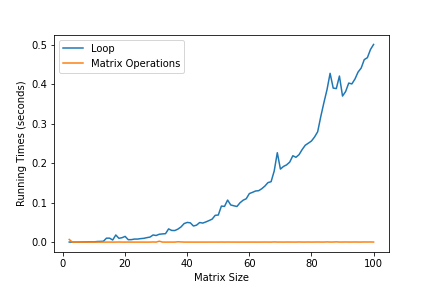

In [11]:
from IPython.display import Image
Image(filename='comparison-problem-01.png')

Likewise, the running times of the correlation nested loop-based function vs. correlation vectorized function over square matrices of dimension 2 to 100 was plotted using `matplotlib` and looks like:

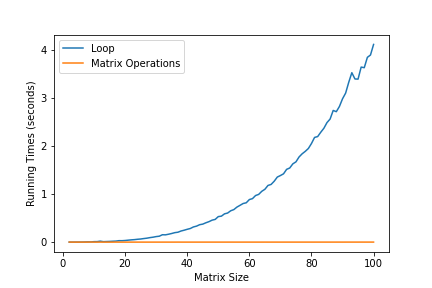

In [12]:
Image(filename='comparison-problem-02.png')

And the bar chart for running times of the distance functions on each of the three datasets:

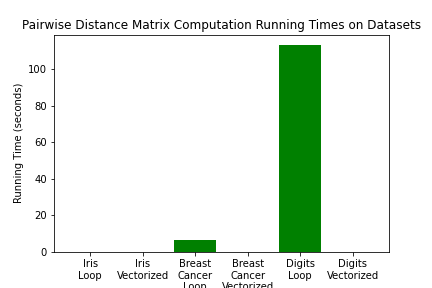

In [13]:
Image(filename='datasets-distance-bar-chart.png')

With corresponding table:

$\begin{bmatrix} 
  & Loop & Vectorized \\
 Iris & 0.1510970079999936 & 0.0007549089999940861 \\
 Breast\ Cancer & 6.3926503510000146 & 0.008255077000001165 \\
 Digits & 113.27628421600002 & 0.09805695200000741
\end{bmatrix}$


And the bar chart for the running times of the correlation functions on each of the three datasets:

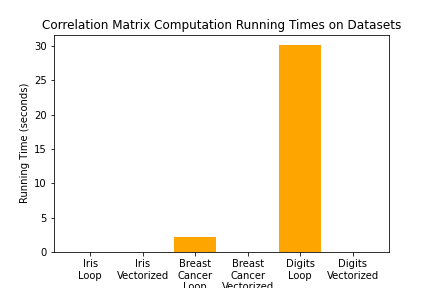

In [14]:
Image(filename='datasets-correlation-bar-chart.png')

With corresponding table:

$\begin{bmatrix} 
  & Loop & Vectorized \\
 Iris & 0.00975481400000433 & 0.00043878099999972164 \\
 Breast\ Cancer & 2.158253350999985 & 0.0014982579999980317 \\
 Digits & 30.146993707000007 & 0.011665293000021393
\end{bmatrix}$

### 2.3. – Discussion

We see from the plots and tables that the vectorized method is several orders of magnitude faster than the loop-based method. From this we can tell that vectorization leads to massive performance increases when working with array data. This is even more pronounced when considering scale: the order-of-magnitude difference in performance only grows with the size of the matrix, as we can tell from the plot comparing them:

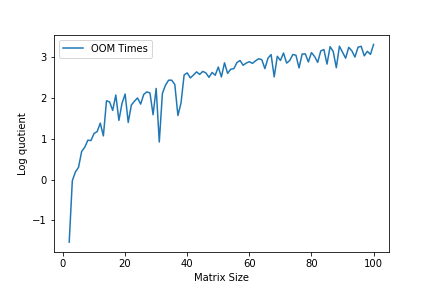

In [15]:
Image(filename='comparison-problem-01-logs.png') # order of magnitude difference in performance: pairwise distance matrix vectorization vs. loop

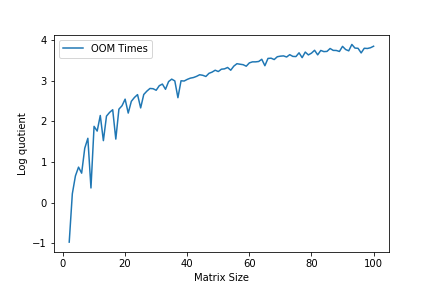

In [16]:
Image(filename='comparison-problem-02-logs.png') # order of magnitude difference in performance: correlation matrix vectorization vs. loop

It's clear that when possible, one ought to consider using vectorization instead of loop-based methods when performance is critical.